# Society of Business, IITR
## Open Project Summer 2025

**Title** : Optimizing Air Travel Through Flight Delay Prediction \
**Done by** : Aashanvit Janbandhu \
**Enrollment No.** : 23125002 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             mean_absolute_error, mean_squared_error)
from xgboost import XGBRegressor


import shap
import warnings
warnings.filterwarnings('ignore')


df=pd.read_csv('./Airline_Delay_Cause.csv')


In [3]:
airport_mapping = df.groupby('airport')['airport_name'].nunique().sort_values(ascending=False)

multiple_names = airport_mapping[airport_mapping > 1]
multiple_names

new_name = df.groupby('airport')['airport_name'].agg(lambda x: x.value_counts().idxmax())

df['air'] = df['airport'].map(new_name)
df.drop(columns=['airport_name'], inplace=True)
df.rename(columns={'air': 'airport_name'}, inplace=True)


In [4]:
carrier_mapping = df.groupby('carrier')['carrier_name'].nunique().sort_values(ascending=False)

multiple_names = carrier_mapping[carrier_mapping > 1]
multiple_names

new_name = df.groupby('carrier')['carrier_name'].agg(lambda x: x.value_counts().idxmax())

df['c'] = df['carrier'].map(new_name)
df.drop(columns=['carrier_name'], inplace=True)
df.rename(columns={'c': 'carrier_name'}, inplace=True)

In [5]:
df['carrier_name'].value_counts().shape

(29,)

In [6]:
df['carrier'].value_counts().shape

(29,)

In [7]:
df['airport'].value_counts().shape

(396,)

In [8]:
df['airport_name'].value_counts().shape

(396,)

In [9]:
df.shape

(179338, 21)

In [10]:
result = df.groupby(['airport', 'year', 'month'])['carrier'].agg([
    ('unique_carrier_count', lambda x: x.nunique()),
    ('unique_carriers',lambda x: list(x.unique()))
]).reset_index()


In [11]:
result

,airport,year,month,unique_carrier_count,unique_carriers
0,ABE,2015,1,2,"[DL, EV]"
1,ABE,2015,2,2,"[DL, EV]"
2,ABE,2015,3,3,"[DL, EV, OO]"
3,ABE,2015,4,3,"[DL, EV, OO]"
4,ABE,2015,5,3,"[DL, EV, OO]"
...,...,...,...,...,...
36976,YUM,2023,8,2,"[MQ, OO]"
36977,YUM,2023,9,2,"[MQ, OO]"
36978,YUM,2023,10,2,"[MQ, OO]"
36979,YUM,2023,11,2,"[MQ, OO]"


In [12]:
result['unique_carrier_count'].max()

np.int64(21)

In [13]:
df = df.sort_values(by=['airport', 'year', 'month', 'carrier']).reset_index(drop=True)


In [14]:
df.dropna(axis=0, inplace=True)

In [15]:
df.shape

(178747, 21)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178747 entries, 0 to 179337
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 178747 non-null  int64  
 1   month                178747 non-null  int64  
 2   carrier              178747 non-null  object 
 3   airport              178747 non-null  object 
 4   arr_flights          178747 non-null  float64
 5   arr_del15            178747 non-null  float64
 6   carrier_ct           178747 non-null  float64
 7   weather_ct           178747 non-null  float64
 8   nas_ct               178747 non-null  float64
 9   security_ct          178747 non-null  float64
 10  late_aircraft_ct     178747 non-null  float64
 11  arr_cancelled        178747 non-null  float64
 12  arr_diverted         178747 non-null  float64
 13  arr_delay            178747 non-null  float64
 14  carrier_delay        178747 non-null  float64
 15  weather_delay        1

In [17]:
df.describe()

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
count,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000
mean,2019.478604,6.488411,328.263244,58.709086,18.598619,2.038589,17.118839,0.145511,20.807539,6.827555,0.780545,3868.713998,1327.400141,209.405898,821.096086,6.849508,1503.955406
std,2.412093,3.464885,931.575550,164.378035,47.417686,6.899212,56.315314,0.702619,64.953490,41.471159,3.492814,11909.596123,4070.328372,792.332527,3180.677510,40.467958,4881.265039
min,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.000000,3.000000,41.000000,6.000000,1.970000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,290.000000,91.000000,0.000000,28.000000,0.000000,55.000000
50%,2020.000000,6.000000,89.000000,15.000000,5.420000,0.220000,3.310000,0.000000,4.300000,1.000000,0.000000,903.000000,322.000000,12.000000,124.000000,0.000000,287.000000
75%,2022.000000,10.000000,218.000000,40.000000,14.730000,1.630000,9.880000,0.000000,13.040000,3.000000,1.000000,2552.000000,988.000000,131.000000,401.500000,0.000000,966.000000
max,2023.000000,12.000000,21977.000000,4176.000000,1293.910000,266.420000,1884.420000,58.690000,2069.070000,4951.000000,160.000000,438783.000000,196944.000000,31960.000000,112018.000000,3760.000000,227959.000000



--- Basic Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 178747 entries, 0 to 179337
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 178747 non-null  int64  
 1   month                178747 non-null  int64  
 2   carrier              178747 non-null  object 
 3   airport              178747 non-null  object 
 4   arr_flights          178747 non-null  float64
 5   arr_del15            178747 non-null  float64
 6   carrier_ct           178747 non-null  float64
 7   weather_ct           178747 non-null  float64
 8   nas_ct               178747 non-null  float64
 9   security_ct          178747 non-null  float64
 10  late_aircraft_ct     178747 non-null  float64
 11  arr_cancelled        178747 non-null  float64
 12  arr_diverted         178747 non-null  float64
 13  arr_delay            178747 non-null  float64
 14  carrier_delay        178747 non-null  float64
 15  we

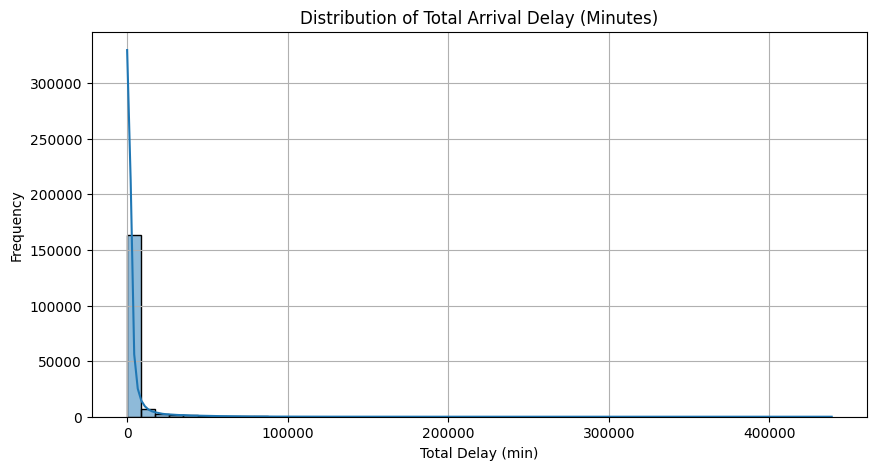

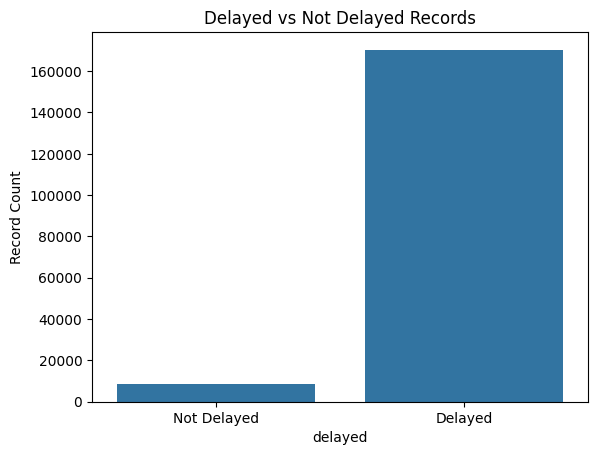

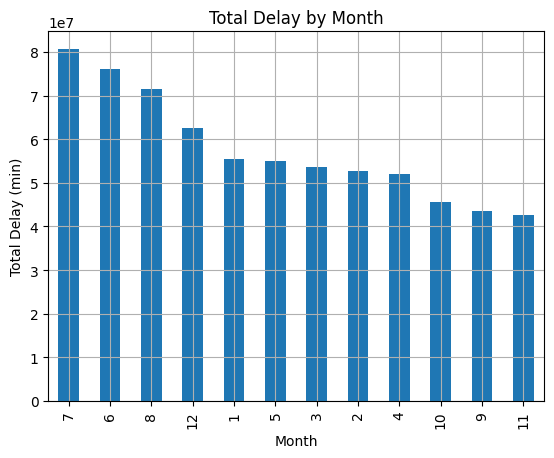

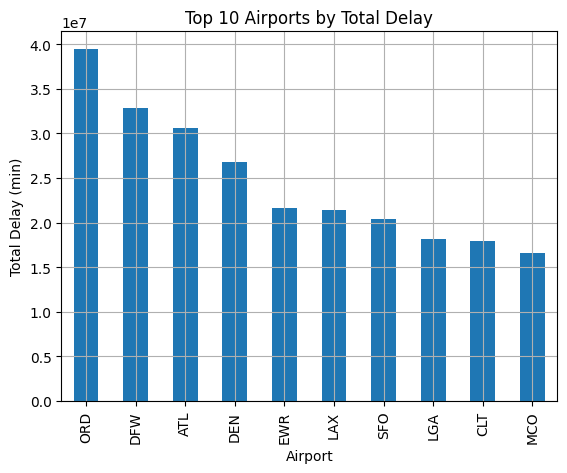

In [18]:
# ---------------------------- EDA ---------------------------- #

# Basic overview
print("\n--- Basic Info ---")
print(df.info())
print("\n--- Missing Values ---")
print(df.isnull().sum())

# Summary statistics
print("\n--- Summary Statistics ---")
print(df.describe())

# Delay distribution
plt.figure(figsize=(10,5))
sns.histplot(df['arr_delay'], bins=50, kde=True)
plt.title("Distribution of Total Arrival Delay (Minutes)")
plt.xlabel("Total Delay (min)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Flights delayed (arr_del15 > 0)
df['delayed'] = (df['arr_del15'] > 0).astype(int)
sns.countplot(x='delayed', data=df)
plt.title("Delayed vs Not Delayed Records")
plt.xticks([0,1], ["Not Delayed", "Delayed"])
plt.ylabel("Record Count")
plt.show()

# Delay vs Month
month_delay = df.groupby('month')['arr_delay'].sum().sort_values(ascending=False)
month_delay.plot(kind='bar', title="Total Delay by Month")
plt.xlabel("Month")
plt.ylabel("Total Delay (min)")
plt.grid(True)
plt.show()

# Delay by Airport
top_airports = df.groupby('airport')['arr_delay'].sum().sort_values(ascending=False).head(10)
top_airports.plot(kind='bar', title="Top 10 Airports by Total Delay")
plt.xlabel("Airport")
plt.ylabel("Total Delay (min)")
plt.grid(True)
plt.show()



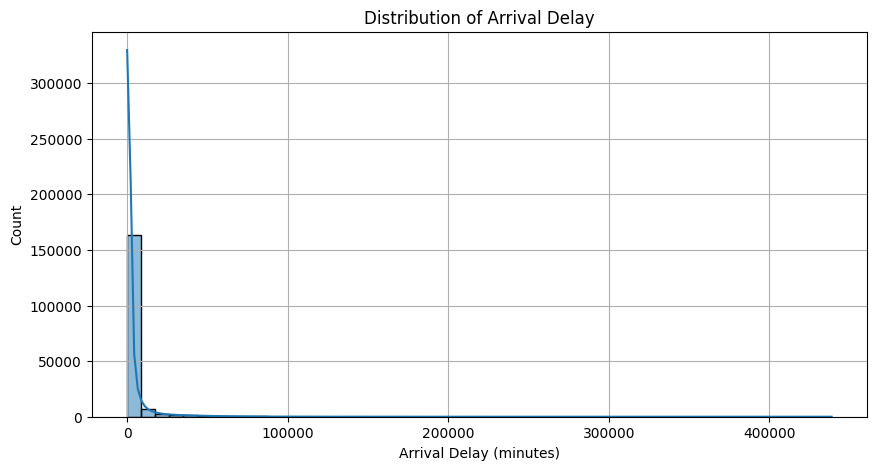

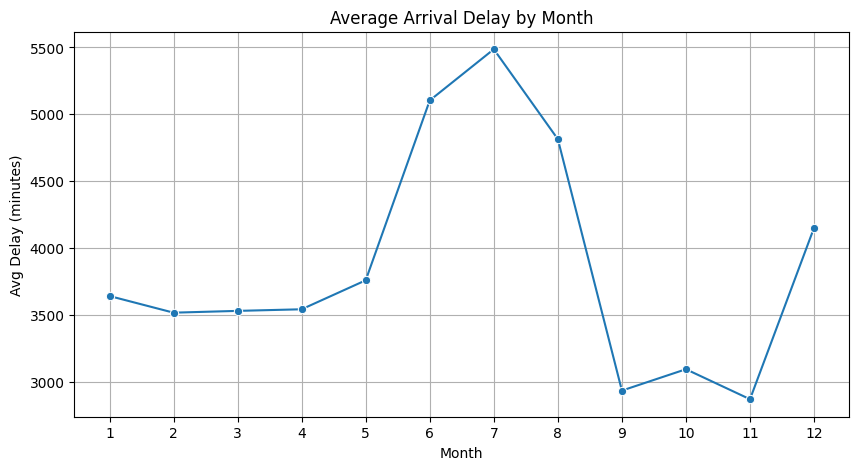

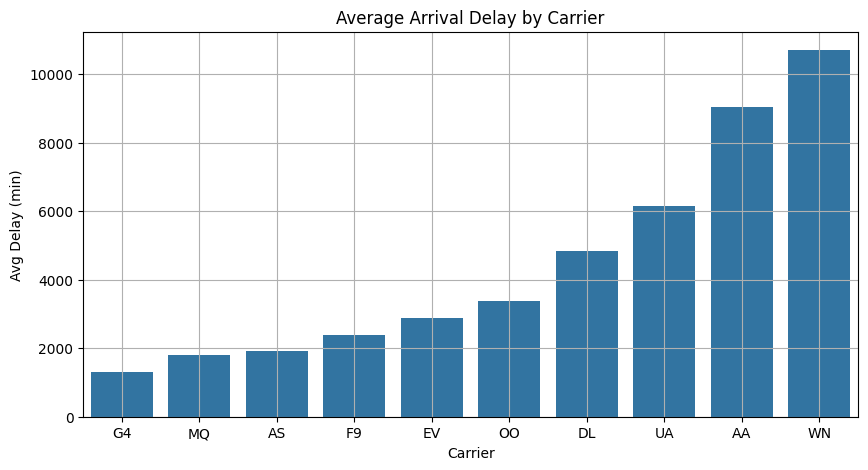

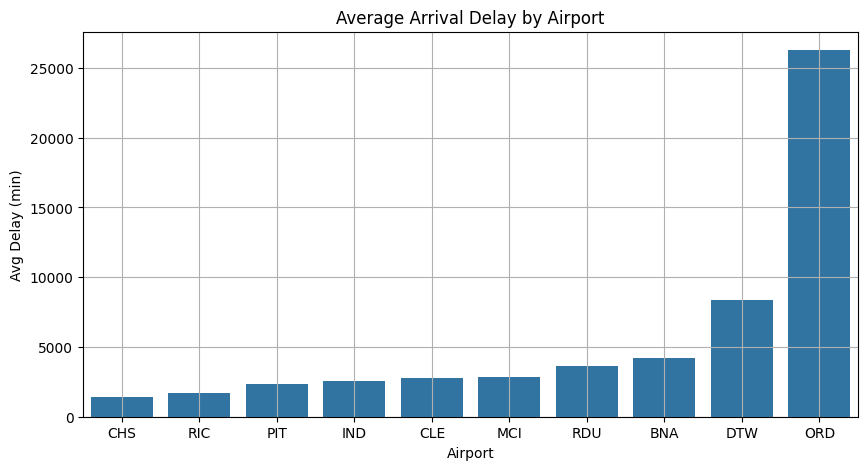

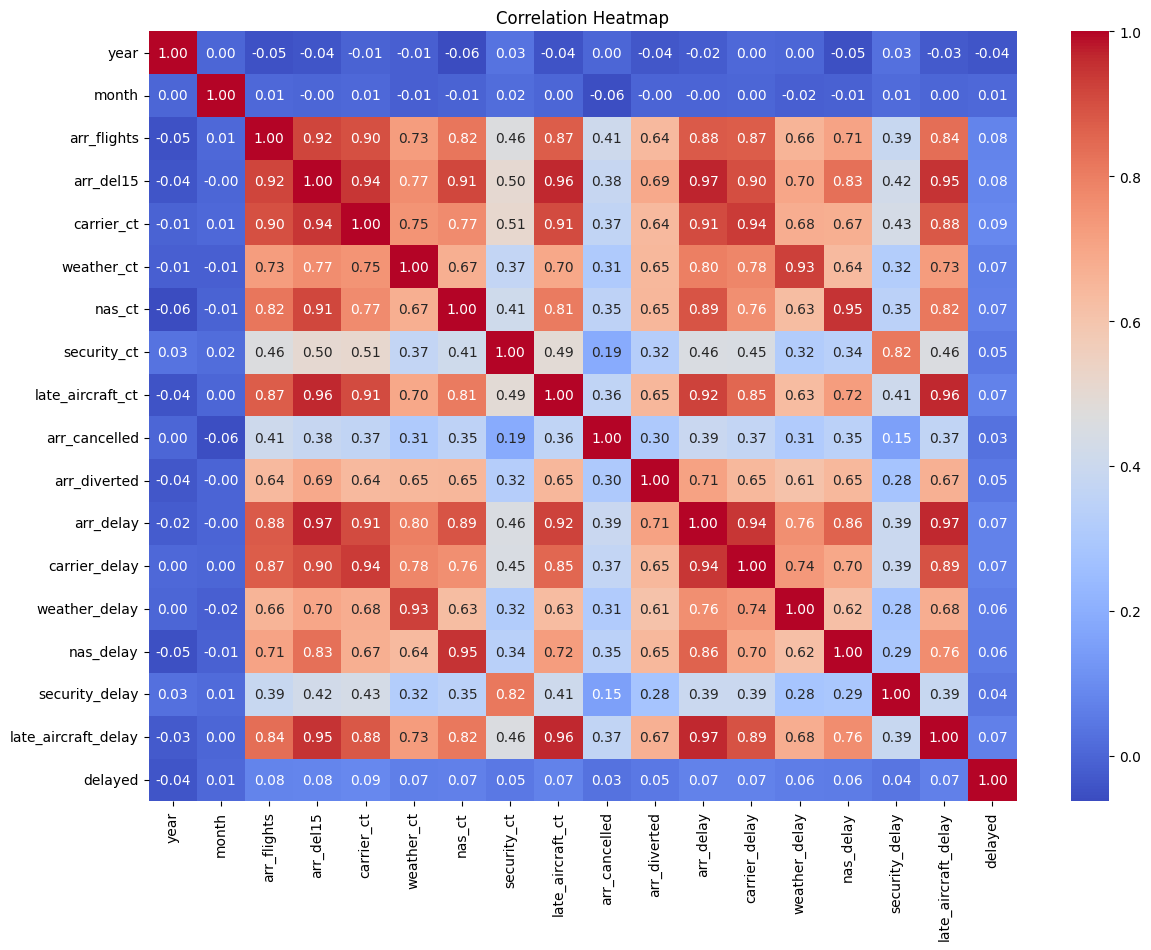

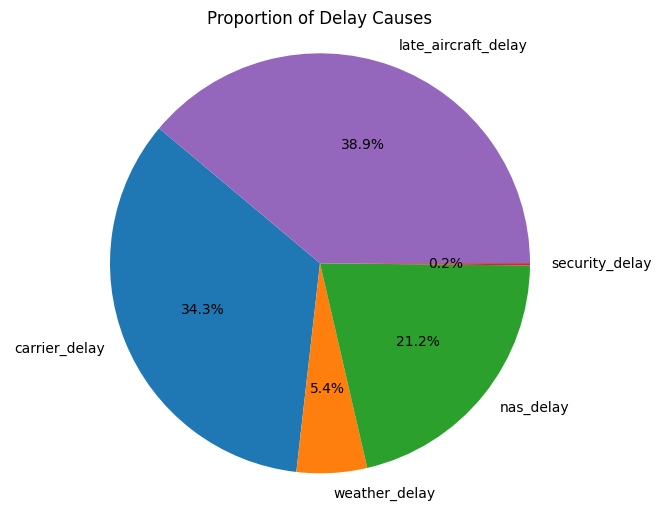

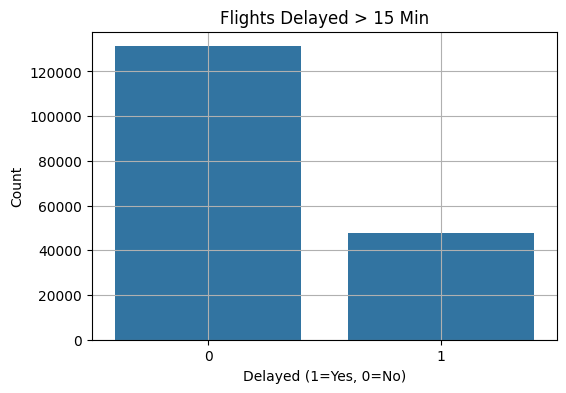

In [20]:
delay_cols = ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']
for col in delay_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)
#  1. Distribution of total arrival delay
plt.figure(figsize=(10,5))
sns.histplot(df['arr_delay'], bins=50, kde=True)
plt.title("Distribution of Arrival Delay")
plt.xlabel("Arrival Delay (minutes)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

#  2. Monthly average delay (if 'month' exists)
if 'month' in df.columns:
    monthly = df.groupby('month')['arr_delay'].mean()
    plt.figure(figsize=(10,5))
    sns.lineplot(x=monthly.index, y=monthly.values, marker='o')
    plt.title("Average Arrival Delay by Month")
    plt.xlabel("Month")
    plt.ylabel("Avg Delay (minutes)")
    plt.grid(True)
    plt.xticks(range(1,13))
    plt.show()

# 3. Carrier-wise average delay
if 'carrier' in df.columns:
    top_carriers = df['carrier'].value_counts().head(10).index
    c_delay = df[df['carrier'].isin(top_carriers)].groupby('carrier')['arr_delay'].mean().sort_values()
    plt.figure(figsize=(10,5))
    sns.barplot(x=c_delay.index, y=c_delay.values)
    plt.title("Average Arrival Delay by Carrier")
    plt.xlabel("Carrier")
    plt.ylabel("Avg Delay (min)")
    plt.grid(True)
    plt.show()

#  4. Airport-wise average delay
if 'airport' in df.columns:
    top_airports = df['airport'].value_counts().head(10).index
    a_delay = df[df['airport'].isin(top_airports)].groupby('airport')['arr_delay'].mean().sort_values()
    plt.figure(figsize=(10,5))
    sns.barplot(x=a_delay.index, y=a_delay.values)
    plt.title("Average Arrival Delay by Airport")
    plt.xlabel("Airport")
    plt.ylabel("Avg Delay (min)")
    plt.grid(True)
    plt.show()

#  5. Correlation heatmap
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

#  6. Pie chart of delay causes
delay_totals = df[delay_cols].sum()
plt.figure(figsize=(8,6))
plt.pie(delay_totals, labels=delay_cols, autopct='%1.1f%%', startangle=140)
plt.title("Proportion of Delay Causes")
plt.axis('equal')
plt.show()

#  7. Flights delayed > 15 mins
df['avg_delay'] = df['arr_delay'] / df['arr_flights']
df['delayed_label'] = (df['avg_delay'] > 15).astype(int)
plt.figure(figsize=(6,4))
sns.countplot(x='delayed_label', data=df)
plt.title("Flights Delayed > 15 Min")
plt.xlabel("Delayed (1=Yes, 0=No)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [21]:
# Example: fill missing delay component values with 0
delay_cols = ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']
for col in delay_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# Drop rows with missing total arrival delay
df = df.dropna(subset=['arr_delay'])

print("After cleaning, data shape:", df.shape)

After cleaning, data shape: (178747, 24)


In [22]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cat_cols = ['carrier', 'airport']  # add more if needed
for col in cat_cols:
    if col in df.columns:
        
        df[col] = le.fit_transform(df[col].astype(str))


In [23]:

# Compute average delay per flight
df['avg_delay'] = df['arr_delay'] / df['arr_flights']
# Binary label: 1 if average delay > 15 minutes
df['delayed_label'] = (df['avg_delay'] > 15).astype(int)
# Operational Adjustability Index
# Avoid division by zero by setting OAI=0 when arr_delay is 0
df['OAI'] = (df['carrier_delay'] + df['late_aircraft_delay']) / df['arr_delay'].replace(0, 1)


In [24]:
from sklearn.model_selection import train_test_split

features = ['year','month','carrier','airport','arr_flights','arr_del15','carrier_ct',
            'weather_ct','nas_ct','security_ct','late_aircraft_ct','arr_cancelled',
            'arr_diverted','carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay']

# Features (ensure arr_delay and avg_delay themselves are not included as features to avoid leakage)
X = df[features]
y_cls = df['delayed_label']
y_reg = df['avg_delay']
sample_weights = df['OAI']  # for classification weighting

# Classification split
X_train_cls, X_test_cls, y_train_cls, y_test_cls, w_train, w_test = train_test_split(
    X, y_cls, sample_weights, test_size=0.3, random_state=42)

# Regression split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.3, random_state=42)


In [25]:
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Classification model with grid search
clf = RandomForestClassifier(random_state=0)
param_grid_clf = {'n_estimators': [50, 100], 'max_depth': [5, 10, None]}
grid_clf = GridSearchCV(clf, param_grid_clf, cv=3, scoring='accuracy', n_jobs=-1)
grid_clf.fit(X_train_cls, y_train_cls, sample_weight=w_train)
best_clf = grid_clf.best_estimator_
print("Best classifier params:", grid_clf.best_params_)

# Regression model with grid search
reg = RandomForestRegressor(random_state=0)
param_grid_reg = {'n_estimators': [50, 100], 'max_depth': [5, 10, None]}
grid_reg = GridSearchCV(reg, param_grid_reg, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_reg.fit(X_train_reg, y_train_reg)
best_reg = grid_reg.best_estimator_
print("Best regressor params:", grid_reg.best_params_)


Best classifier params: {'max_depth': None, 'n_estimators': 100}
Best regressor params: {'max_depth': None, 'n_estimators': 100}


In [26]:


# Classification predictions
y_pred_cls = best_clf.predict(X_test_cls)
y_prob_cls = best_clf.predict_proba(X_test_cls)[:,1]
acc = accuracy_score(y_test_cls, y_pred_cls)
prec = precision_score(y_test_cls, y_pred_cls, zero_division=0)
rec = recall_score(y_test_cls, y_pred_cls)
f1 = f1_score(y_test_cls, y_pred_cls)
roc_auc = roc_auc_score(y_test_cls, y_prob_cls)
cm = confusion_matrix(y_test_cls, y_pred_cls)

print(f"Classification - Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}, ROC-AUC: {roc_auc:.3f}")
print("Confusion Matrix:\n", cm)

# Regression predictions
y_pred_reg = best_reg.predict(X_test_reg)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = mean_squared_error(y_test_reg, y_pred_reg)
# Compute OAI-weighted MAE on the test set
w_test = df.loc[y_test_reg.index, 'OAI']
weighted_mae = (abs(y_test_reg - y_pred_reg) * w_test).sum() / w_test.sum()
print(f"Regression - MAE: {mae:.3f}, RMSE: {rmse:.3f}, OAI-weighted MAE: {weighted_mae:.3f}")


Classification - Accuracy: 0.957, Precision: 0.936, Recall: 0.901, F1: 0.918, ROC-AUC: 0.993
Confusion Matrix:
 [[38394   885]
 [ 1415 12931]]
Regression - MAE: 0.704, RMSE: 158.241, OAI-weighted MAE: 0.709


 99%|===================| 596/600 [00:55<00:00]        

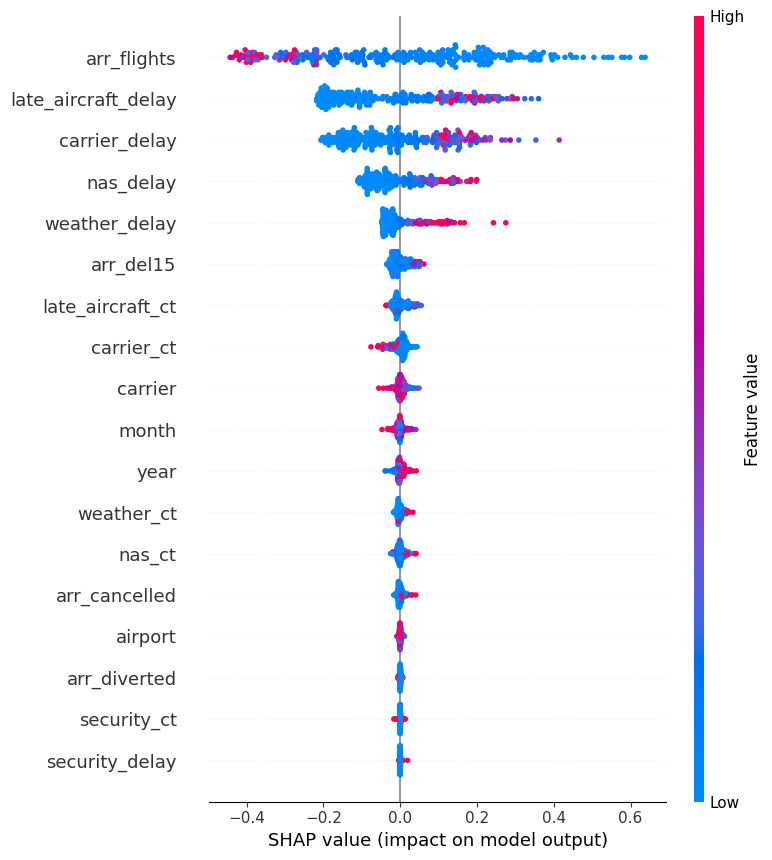

In [27]:
# 1. Sample small batch
X_sample = X_test_cls.sample(n=300, random_state=42)

# 2. Use new SHAP API
explainer = shap.Explainer(best_clf, X_sample)

# 3. Compute SHAP values with additivity check off
shap_values = explainer(X_sample, check_additivity=False)

# 4. Global summary plot (for class 1)
shap.summary_plot(shap_values[:, :, 1], X_sample)



In [28]:
# Prepare DataFrames for export
results_cls = X_test_cls.copy()
results_cls['true_label'] = y_test_cls
results_cls['pred_label'] = y_pred_cls
results_cls['pred_prob'] = y_prob_cls
results_cls['OAI'] = w_test
results_cls.to_csv("classification_predictions.csv", index=False)

results_reg = X_test_reg.copy()
results_reg['true_avg_delay'] = y_test_reg
results_reg['pred_avg_delay'] = y_pred_reg
results_reg['OAI'] = w_test
df['carrier_name'] = le.inverse_transform(df['carrier'])
df['airport_name'] = le.inverse_transform(df['airport'])
results_reg.to_csv("regression_predictions.csv", index=False)
